In [33]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.stem.porter import *

from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, pipeline, metrics, grid_search

from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.utils import np_utils

In [2]:
# Load the training file
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# we dont need ID columns
idx = test.id.values.astype(int)
train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

# non values를 " "으로 채우기
train = train.fillna(" ")
test  = test.fillna(" ")

#remove html, remove non text or numeric, make query and title unique features for counts using prefix (accounted for in stopwords tweak)
stemmer = PorterStemmer()

## Stemming functionality
class stemmerUtility(object):
    """Stemming functionality"""
    @staticmethod
    def stemPorter(review_text):
        porter = PorterStemmer()
        preprocessed_docs = []
        for doc in review_text:
            final_doc = []
            for word in doc:
                final_doc.append(porter.stem(word))
                #final_doc.append(wordnet.lemmatize(word)) #note that lemmatize() can also takes part of speech as an argument!
            preprocessed_docs.append(final_doc)
        return preprocessed_docs

def clean(text):
    text = BeautifulSoup(text).get_text(" ")
    text = re.sub("[^a-zA-Z0-9]"," ", text)
    text = (" ").join([stemmer.stem(z) for z in text.split()])
    return text

def cleanq(text):
    text = BeautifulSoup(text).get_text(" ")
    text = re.sub("[^a-zA-Z0-9]"," ", text)
    text = (" ").join(["q" + stemmer.stem(z) for z in text.split()])
    return text

def cleant(text):
    text = BeautifulSoup(text).get_text(" ")
    text = re.sub("[^a-zA-Z0-9]"," ", text)
    text = (" ").join(["t" + stemmer.stem(z) for z in text.split()])
    return text

# clean data
train['query'] = train['query'].apply(func=cleanq)
train['product_title'] = train['product_title'].apply(func=cleant)
train['product_description'] = train['product_description'].apply(func=clean)

test['query'] = test['query'].apply(func=cleanq)
test['product_title'] = test['product_title'].apply(func=cleant)
test['product_description'] = test['product_description'].apply(func=clean)

/home/ubuntu/anaconda/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65497012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.' % markup)
/home/ubuntu/anaconda/lib/python2.7/site-packages/bs4/__init__.py:189: UserWarning: "http://i104.photobucket.com/albums/m175/champions_on_display/wincraft2013/januaryb/65516012.jpg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client to get the document behind the URL, and feed that document to Beautiful Soup.
  '"%s" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP cl

In [3]:
def merge_rows(x):
    query = x[0]
    product_title = x[1]
    product_description  = x[2]
    return query + ' ' + product_title + ' ' + product_description

trainX = train[['query', 'product_title', 'product_description']].apply(func=merge_rows, axis=1)
trainY = train["median_relevance"]

testX = test[['query', 'product_title', 'product_description']].apply(func=merge_rows, axis=1)

In [4]:
# the infamous tfidf vectorizer (Do you remember this one?)
tfv = TfidfVectorizer(min_df=3,  max_features=None, max_df=500,
        strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}',
        ngram_range=(1, 2), use_idf=1, smooth_idf=1, sublinear_tf=1,
        stop_words = 'english')

# Fit TFIDF
tfv.fit(trainX)
trainX =  tfv.transform(trainX)
testX = tfv.transform(testX)

In [5]:
y_train = np_utils.to_categorical(trainY.values - 1, 4)

In [6]:
max_features=20000
maxlen = 100 # cut texts after this number of words (among top max_features most common words)
batch_size = 10
nb_epoch = 5

print "Pad sequences (samples x time)"
X_train = sequence.pad_sequences(trainX.toarray(), maxlen=maxlen)
X_test = sequence.pad_sequences(testX.toarray(), maxlen=maxlen)
print 'X_train shape:', X_train.shape
print 'X_test shape:', X_test.shape

print('Build model...')
model = Sequential()
model.add(Embedding(10158 , 256))
model.add(LSTM(256, 128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 4))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', class_mode="binary")

print "Train..."
mm = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.1, show_accuracy=True)
score = model.evaluate(X_train, y_train, batch_size=batch_size)
print 'Test score:', score

classes = model.predict_classes(X_train, batch_size=batch_size)
acc = np_utils.accuracy(classes, y_train)
print 'accuracy:', acc

Pad sequences (samples x time)
X_train shape: (10158, 100)
X_test shape: (22513, 100)
Build model...
Train...
Train on 9142 samples, validate on 1016 samples
Epoch 0
9142/9142 [==============================] - 116s - loss: 0.4621 - acc.: 0.8003 - val. loss: 0.4421 - val. acc.: 0.8105
Epoch 1
9142/9142 [==============================] - 172s - loss: 0.4581 - acc.: 0.8029 - val. loss: 0.4433 - val. acc.: 0.8105
Epoch 2
9142/9142 [==============================] - 183s - loss: 0.4569 - acc.: 0.8032 - val. loss: 0.4426 - val. acc.: 0.8105
Epoch 3
9142/9142 [==============================] - 191s - loss: 0.4573 - acc.: 0.8028 - val. loss: 0.4422 - val. acc.: 0.8105
Epoch 4
10158/10158 [==============================] - 32s - loss: 0.4529    
Test score: 0.452898901469
10158/10158 [==============================] - 30s    
accuracy: 0.803750738334


/home/ubuntu/anaconda/lib/python2.7/site-packages/theano/gof/cmodule.py:293: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  rval = __import__(module_name, {}, {}, [module_name])


In [7]:
df = pd.DataFrame({'epoch' : mm.epoch, 'loss' : mm.loss, 'accuracy' : mm.accuracy})
df.index = df['epoch']

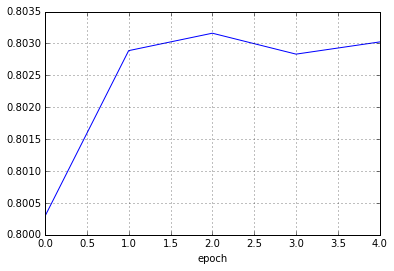

In [10]:
df['accuracy'].plot()

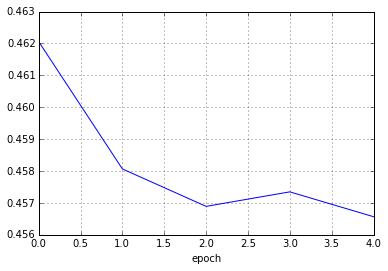

In [11]:
df['loss'].plot()

In [18]:
# 앞에서 1을 빼줬으니 1을 다시 더해주자
prediction = model.predict_classes(X_test, batch_size=batch_size)
prediction = np_utils.probas_to_classes(prediction)
prediction = prediction + 1

# Create your submission file
submission = pd.DataFrame({"id": idx, "prediction": prediction})
submission.to_csv("submission.csv", index=False)

22513/22513 [==============================] - 53s    


In [19]:
# 결과값이 4밖에 없다.
!ls submission.csv
print submission.head(2)
print pd.unique(submission['prediction'])

submission.csv
   id  prediction
0   3           4
1   6           4
[4]


In [36]:
# kaggle에 제출해보자 얼마나 나올까?
# Your submission scored 0.00000, which is not an improvement of your best score. Keep trying!

In [37]:
# optimizer를 sgd로 바꿔보자

max_features=20000
maxlen = 100 # cut texts after this number of words (among top max_features most common words)
batch_size = 10
nb_epoch = 3

print "Pad sequences (samples x time)"
X_train = sequence.pad_sequences(trainX.toarray(), maxlen=maxlen)
X_test = sequence.pad_sequences(testX.toarray(), maxlen=maxlen)
print 'X_train shape:', X_train.shape
print 'X_test shape:', X_test.shape

print('Build model...')
model = Sequential()
model.add(Embedding(10158 , 256))
model.add(LSTM(256, 128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 4))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, class_mode="binary")

print "Train..."
mm = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.1, show_accuracy=True)
score = model.evaluate(X_train, y_train, batch_size=batch_size)
print 'Test score:', score

classes = model.predict_classes(X_train, batch_size=batch_size)
acc = np_utils.accuracy(classes, y_train)
print 'accuracy:', acc

prediction = model.predict_classes(X_test, batch_size=batch_size)
prediction = np_utils.probas_to_classes(prediction)
prediction = prediction + 1
print np.unique(prediction)

Pad sequences (samples x time)
X_train shape: (10158, 100)
X_test shape: (22513, 100)
Build model...
Train...
Train on 9142 samples, validate on 1016 samples
Epoch 0
9142/9142 [==============================] - 114s - loss: 0.4589 - acc.: 0.8026 - val. loss: 0.4448 - val. acc.: 0.8105
Epoch 1
9142/9142 [==============================] - 180s - loss: 0.4549 - acc.: 0.8030 - val. loss: 0.4432 - val. acc.: 0.8105
Epoch 2
10158/10158 [==============================] - 23s - loss: 0.4530    
Test score: 0.453014531622
10158/10158 [==============================] - 24s    
accuracy: 0.803750738334
22513/22513 [==============================] - 53s    
[4]


In [38]:
df = pd.DataFrame({'epoch' : mm.epoch, 'loss' : mm.loss, 'accuracy' : mm.accuracy})
df.index = df['epoch']

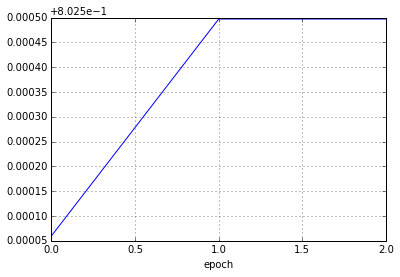

In [39]:
df['accuracy'].plot()

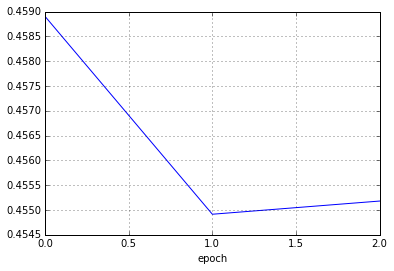

In [42]:
df['loss'].plot()

In [43]:
# optimizer를 Adagrad로 바꿔보자

max_features=20000
maxlen = 100 # cut texts after this number of words (among top max_features most common words)
batch_size = 10
nb_epoch = 3

print "Pad sequences (samples x time)"
X_train = sequence.pad_sequences(trainX.toarray(), maxlen=maxlen)
X_test = sequence.pad_sequences(testX.toarray(), maxlen=maxlen)
print 'X_train shape:', X_train.shape
print 'X_test shape:', X_test.shape

print('Build model...')
model = Sequential()
model.add(Embedding(10158 , 256))
model.add(LSTM(256, 128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 4))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
adagrad = Adagrad(lr=0.01, epsilon=1e-6)
model.compile(loss='binary_crossentropy', optimizer=adagrad, class_mode="categorical")

print "Train..."
mm = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.1, show_accuracy=True)
score = model.evaluate(X_train, y_train, batch_size=batch_size)
print 'Test score:', score

classes = model.predict_classes(X_train, batch_size=batch_size)
acc = np_utils.accuracy(classes, y_train)
print 'accuracy:', acc

prediction = model.predict_classes(X_test, batch_size=batch_size)
prediction = np_utils.probas_to_classes(prediction)
prediction = prediction + 1
print np.unique(prediction)

Pad sequences (samples x time)
X_train shape: (10158, 100)
X_test shape: (22513, 100)
Build model...
Train...
Train on 9142 samples, validate on 1016 samples
Epoch 0
9142/9142 [==============================] - 229s - loss: 0.4596 - acc.: 0.6053 - val. loss: 0.4419 - val. acc.: 0.6211
Epoch 1
9142/9142 [==============================] - 225s - loss: 0.4574 - acc.: 0.6060 - val. loss: 0.4428 - val. acc.: 0.6211
Epoch 2
10158/10158 [==============================] - 39s - loss: 0.4530    
Test score: 0.452991848851
10158/10158 [==============================] - 36s    
accuracy: 0.0
22513/22513 [==============================] - 88s    
[2]


In [44]:
df = pd.DataFrame({'epoch' : mm.epoch, 'loss' : mm.loss, 'accuracy' : mm.accuracy})
df.index = df['epoch']

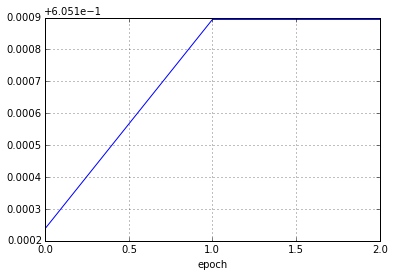

In [45]:
df['accuracy'].plot()

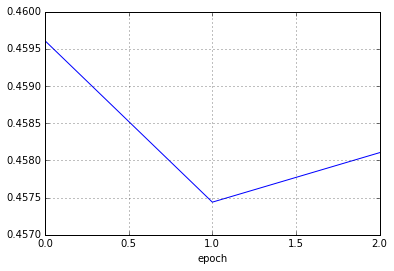

In [46]:
df['loss'].plot()

In [47]:
# optimizer를 Adadelta로 바꿔보자

max_features=20000
maxlen = 100 # cut texts after this number of words (among top max_features most common words)
batch_size = 10
nb_epoch = 3

print "Pad sequences (samples x time)"
X_train = sequence.pad_sequences(trainX.toarray(), maxlen=maxlen)
X_test = sequence.pad_sequences(testX.toarray(), maxlen=maxlen)
print 'X_train shape:', X_train.shape
print 'X_test shape:', X_test.shape

print('Build model...')
model = Sequential()
model.add(Embedding(10158 , 256))
model.add(LSTM(256, 128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 4))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=1e-6)
model.compile(loss='binary_crossentropy', optimizer=adadelta, class_mode="categorical")

print "Train..."
mm = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.1, show_accuracy=True)
score = model.evaluate(X_train, y_train, batch_size=batch_size)
print 'Test score:', score

classes = model.predict_classes(X_train, batch_size=batch_size)
acc = np_utils.accuracy(classes, y_train)
print 'accuracy:', acc

prediction = model.predict_classes(X_test, batch_size=batch_size)
prediction = np_utils.probas_to_classes(prediction)
prediction = prediction + 1
print np.unique(prediction)

Pad sequences (samples x time)
X_train shape: (10158, 100)
X_test shape: (22513, 100)
Build model...
Train...
Train on 9142 samples, validate on 1016 samples
Epoch 0
9142/9142 [==============================] - 120s - loss: 0.4633 - acc.: 0.6059 - val. loss: 0.4420 - val. acc.: 0.6211
Epoch 1
9142/9142 [==============================] - 120s - loss: 0.4569 - acc.: 0.6060 - val. loss: 0.4441 - val. acc.: 0.6211
Epoch 2
10158/10158 [==============================] - 24s - loss: 0.4531    
Test score: 0.453116839345
10158/10158 [==============================] - 24s    
accuracy: 0.0
22513/22513 [==============================] - 53s    
[2]


In [48]:
df = pd.DataFrame({'epoch' : mm.epoch, 'loss' : mm.loss, 'accuracy' : mm.accuracy})
df.index = df['epoch']

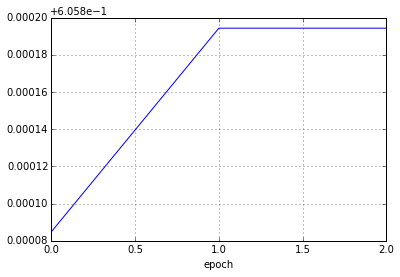

In [49]:
df['accuracy'].plot()

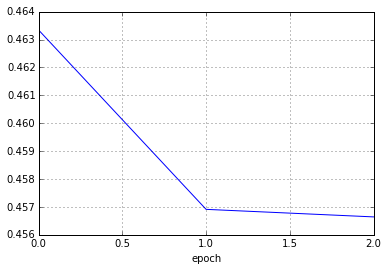

In [50]:
df['loss'].plot()

In [51]:
# optimizer를 RMSprop로 바꿔보자

max_features=20000
maxlen = 100 # cut texts after this number of words (among top max_features most common words)
batch_size = 10
nb_epoch = 3

print "Pad sequences (samples x time)"
X_train = sequence.pad_sequences(trainX.toarray(), maxlen=maxlen)
X_test = sequence.pad_sequences(testX.toarray(), maxlen=maxlen)
print 'X_train shape:', X_train.shape
print 'X_test shape:', X_test.shape

print('Build model...')
model = Sequential()
model.add(Embedding(10158 , 256))
model.add(LSTM(256, 128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 4))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(loss='binary_crossentropy', optimizer=rmsprop, class_mode="categorical")

print "Train..."
mm = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.1, show_accuracy=True)
score = model.evaluate(X_train, y_train, batch_size=batch_size)
print 'Test score:', score

classes = model.predict_classes(X_train, batch_size=batch_size)
acc = np_utils.accuracy(classes, y_train)
print 'accuracy:', acc

prediction = model.predict_classes(X_test, batch_size=batch_size)
prediction = np_utils.probas_to_classes(prediction)
prediction = prediction + 1
print np.unique(prediction)

Pad sequences (samples x time)
X_train shape: (10158, 100)
X_test shape: (22513, 100)
Build model...
Train...
Train on 9142 samples, validate on 1016 samples
Epoch 0
9142/9142 [==============================] - 121s - loss: 0.4651 - acc.: 0.6057 - val. loss: 0.4476 - val. acc.: 0.6211
Epoch 1
9142/9142 [==============================] - 121s - loss: 0.4570 - acc.: 0.6060 - val. loss: 0.4432 - val. acc.: 0.6211
Epoch 2
10158/10158 [==============================] - 25s - loss: 0.4541    
Test score: 0.454128615539
10158/10158 [==============================] - 25s    
accuracy: 0.0
22513/22513 [==============================] - 54s    
[2]


In [52]:
df = pd.DataFrame({'epoch' : mm.epoch, 'loss' : mm.loss, 'accuracy' : mm.accuracy})
df.index = df['epoch']

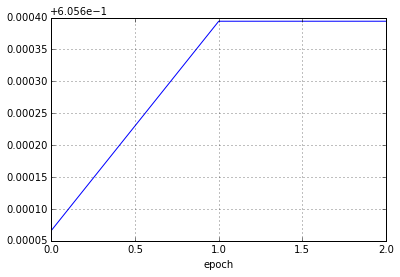

In [53]:
df['accuracy'].plot()

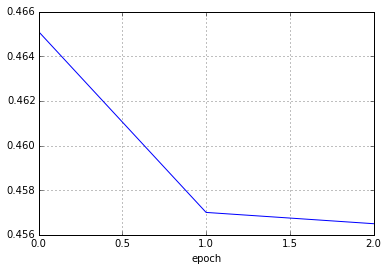

In [54]:
df['loss'].plot()

In [55]:
# optimizer를 Adam로 바꿔보자

max_features=20000
maxlen = 100 # cut texts after this number of words (among top max_features most common words)
batch_size = 10
nb_epoch = 3

print "Pad sequences (samples x time)"
X_train = sequence.pad_sequences(trainX.toarray(), maxlen=maxlen)
X_test = sequence.pad_sequences(testX.toarray(), maxlen=maxlen)
print 'X_train shape:', X_train.shape
print 'X_test shape:', X_test.shape

print('Build model...')
model = Sequential()
model.add(Embedding(10158 , 256))
model.add(LSTM(256, 128)) # try using a GRU instead, for fun
model.add(Dropout(0.5))
model.add(Dense(128, 4))
model.add(Activation('sigmoid'))

# try using different optimizers and different optimizer configs
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, kappa=1-1e-8)
model.compile(loss='binary_crossentropy', optimizer=adam, class_mode="categorical")

print "Train..."
mm = model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.1, show_accuracy=True)
score = model.evaluate(X_train, y_train, batch_size=batch_size)
print 'Test score:', score

classes = model.predict_classes(X_train, batch_size=batch_size)
acc = np_utils.accuracy(classes, y_train)
print 'accuracy:', acc

prediction = model.predict_classes(X_test, batch_size=batch_size)
prediction = np_utils.probas_to_classes(prediction)
prediction = prediction + 1
print np.unique(prediction)

Pad sequences (samples x time)
X_train shape: (10158, 100)
X_test shape: (22513, 100)
Build model...
Train...
Train on 9142 samples, validate on 1016 samples
Epoch 0
9142/9142 [==============================] - 123s - loss: 0.4620 - acc.: 0.6056 - val. loss: 0.4437 - val. acc.: 0.6211
Epoch 1
9142/9142 [==============================] - 124s - loss: 0.4586 - acc.: 0.6060 - val. loss: 0.4423 - val. acc.: 0.6211
Epoch 2
10158/10158 [==============================] - 25s - loss: 0.4532    
Test score: 0.453162053646
10158/10158 [==============================] - 26s    
accuracy: 0.0
22513/22513 [==============================] - 57s    
[2]


In [56]:
df = pd.DataFrame({'epoch' : mm.epoch, 'loss' : mm.loss, 'accuracy' : mm.accuracy})
df.index = df['epoch']

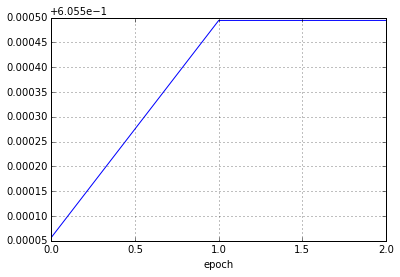

In [57]:
df['accuracy'].plot()

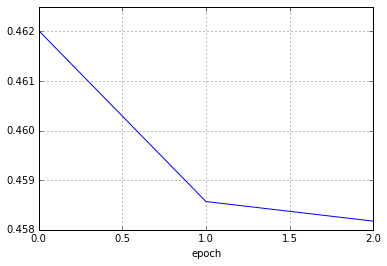

In [58]:
df['loss'].plot()